In [167]:
import numpy as np
import itertools 
from math import comb
import matplotlib.pyplot as plt

In [170]:
n=3
permutations = list(itertools.permutations(list(range(n))))
yes_family = {permutations[i]: i for i in range(len(permutations))}
no_family = set()

for permutation in permutations:
    for i in range(len(permutation)):
        permutation = list(permutation)
        for v in range(n):
            if permutation[i] != v:
                # print(permutation)
                no_family.add(tuple(permutation[:i] + [v] + permutation[i+1:]))

no_family = list(no_family)
# print(no_family)
no_family = {no_family[i]: i for i in range(len(no_family))}

In [177]:
# generates a list of all partial injective functions [n] to [n] with domain size k
def all_injective(n, k):
    print(k)
    injectives_single = list(itertools.combinations(list(range(n)), k))
    return list(itertools.product(injectives_single, injectives_single))

def get_agreeable_indices(partial_injective, family):
    indices = []
    for function, i in family.items():
        # print(i, function)
        agree = True
        for index, output in zip(*partial_injective):
            if function[index] != output:
                agree = False
                break
        if agree:
            indices.append(i)
    return indices

def get_basis_vector(partial_injective, family, n):
    agreeable = get_agreeable_indices(partial_injective, family)
    basis_vector = np.zeros(len(family))
    for i in agreeable:
        basis_vector[i] = 1
    return basis_vector / np.sqrt(len(agreeable))
    
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q
    
def no_space_projection(k, no_fam, n):
    projection = np.zeros((len(no_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    no_vects = [get_basis_vector(injective, no_fam, n) for injective in all_partial_injectives]
    no_vects = np.asmatrix(no_vects).T
    print(no_vects)
    ortho_basis = gram_schmidt_columns(no_vects)
    print('mat', ortho_basis)
    basis_vectors = [np.asmatrix(ortho_basis[:][i]) for i in range(ortho_basis.shape[1])]
    print('blah', basis_vectors[0])
    return projection
                          
def L_matrix(k, yes_fam, no_fam, n):
    projection = np.zeros((len(yes_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    for injective_1 in all_partial_injectives:
        for injective_2 in all_partial_injectives:
            v = get_basis_vector(injective_1, yes_fam, n)
            u = get_basis_vector(injective_2, no_fam, n)
            projection = projection + np.asmatrix(v).T @ np.asmatrix(u)
    
    return projection
    
def H_projection(k, no_fam, n):
    A_k = no_space_projection(k, no_fam, n)
    if k==0:
          return A_k
    I = np.identity(len(no_fam))
    A_km1 = no_space_projection(k-1, no_fam, n)
    return A_k @ (I- A_km1)

def get_adversary_matrix(n, yes_fam, no_fam):
    adv_mat = np.zeros((len(yes_fam), len(no_fam)))
    target = int(n**(2/3))
    print(target)
    for k in range(target):
        adv_mat = adv_mat + (target - k) * L_matrix(k, yes_fam, no_fam, n) @ H_projection(k, no_fam, n)
    return adv_mat
    
    


In [178]:
G = get_adversary_matrix(n, yes_family, no_family)

2
0
0
[[0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]
 [0.23570226]]
mat [[-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]
 [-0.23570226]]
blah [[-0.23570226]]
1
1
[[0.         0.40824829 0.         0.         0.         0.40824829
  0.         0.40824829 0.        ]
 [0.         0.         0.40824829 0.         0.40824829 0.
  0.         0.40824829 0.        ]
 [0.         0.         0.40824829 0.40824829 0.         0.
  0.         0.         0.40824829]
 [0.         0.40824829 0.         0.40824829 0.         0.
  0.         0.40824829 0.        ]
 [0.         0.         0.40824829 0.         0. 

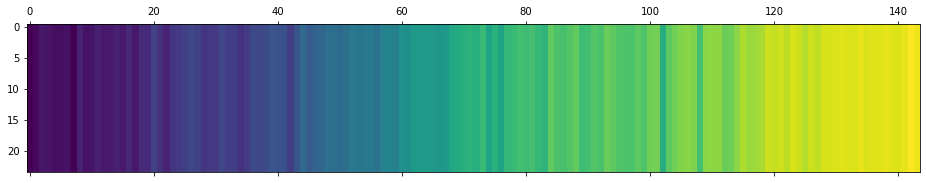

In [169]:
plt.matshow(G)